In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from obspy.taup import TauPyModel
import function_repo as fr
import importlib
importlib.reload(fr)

<module 'function_repo' from 'c:\\Users\\18723\\Documents\\GitHub\\SURG-Mars\\function_repo.py'>

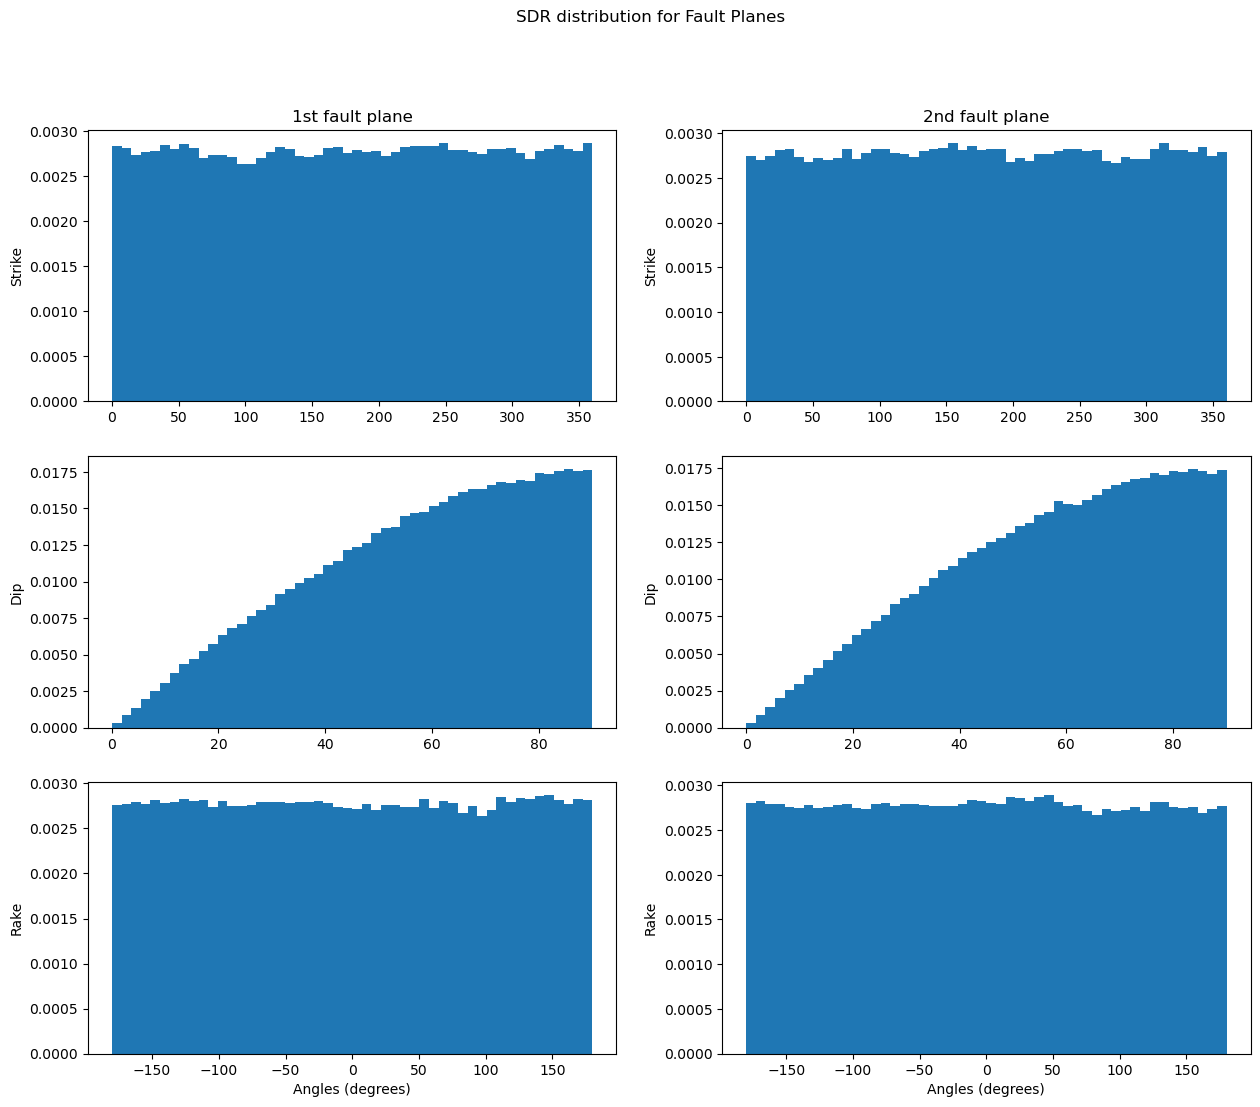

In [3]:
## GENERATING SAMPLES

"""
Explain the sinusoidal dip distribution
How does it influence grid search/predictions?
"""

N = 100
t_samples = fr.hemisphere_samples(N**2)
sdr1 = []
sdr2 = []

for t in t_samples:
    p_rotations = fr.uniform_samples(N, [0, np.pi])
    p_start = fr.starting_direc(t, fr.j_hat)
    for theta in p_rotations:
        p = fr.rotate(p_start, t, theta)
        sdr1_emt, sdr2_emt = fr.tp2sdr(fr.coord_switch(t), fr.coord_switch(p))
        sdr1.append(sdr1_emt)
        sdr2.append(sdr2_emt)

# Histograms for sdr1 and sdr2
fig1 = plt.figure(figsize=(15,12))
plt.suptitle("SDR distribution for Fault Planes")

ylabels = ["Strike", "Dip", "Rake"]

for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.hist([np.rad2deg(emt[i]) for emt in sdr1], bins=50, density=True)
    if i == 0: plt.title("1st fault plane")
    plt.ylabel(ylabels[i])
plt.xlabel("Angles (degrees)")

for i in range(3):
    plt.subplot(3,2,2*(i+1))
    plt.hist([np.rad2deg(emt[i]) for emt in sdr2], bins=50, density=True)
    if i == 0: plt.title("2nd fault plane")
    plt.ylabel(ylabels[i])
    
plt.xlabel("Angles (degrees)")
plt.show()

In [56]:
## TESTING PREDICTIVE POWER

"""
I want to save the results as a dataframe
Turn this into a function that returns a dataframe
given N, hdepth, epdist, azimuth, Ao, Uo and model
This is the main part of the show
"""

model = TauPyModel(model='ak135') # velocity model
hdepth = 15 # km - assumed quake depth
b3_over_a3 = (3.4600/5.8000)**3 # from Maddy's paper, not part of the velocity model
epdist = 10   # good estimate? - use wilbur3
azimuth = 200 # arbitrary
N = 100 # number of samples per s-d pair

# fake an observation of amplitude + uncertainty (normal fault in this case)
# real data will have no known source mechanism
t, p = np.array([1,0,0]), np.array([0,0,1])
faults = fr.tp2sdr(fr.coord_switch(t), fr.coord_switch(p))
faults = [np.rad2deg(np.array(sdr)) for sdr in faults]
scale = stats.uniform.rvs(0.5,10) # necessary?
"""
Confirm scale
"""
arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P', 'S'])
takeoff_angles = [a.takeoff_angle for a in arrivals]
Ao = np.array(fr.Rpattern(faults[0], azimuth, takeoff_angles))*scale
Ao[0] *= b3_over_a3 # Maddy's paper page 5, reread
sigma = 0.1
Uo = np.array([abs(Ao[i])*sigma for i in range(len(Ao))])
print(f"Observation: {Ao}\nUncertainty: {Uo}")


Observation: [-0.81021954 -4.91714978  2.19851802]
Uncertainty: [0.08102195 0.49171498 0.2198518 ]


In [57]:
## DATAFRAME

# df = fr.apply_inverse_methods(N, hdepth, epdist, azimuth, Ao, Uo, model)
# df.to_csv("normal_fault_guess.csv", index=False)